In [ ]:
%%capture

!pip install librosa soundfile

In [ ]:
import os
import tensorflow as tf
import numpy as np
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
import cv2
import collections
import shutil
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D, LSTM
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy, TopKCategoricalAccuracy, CategoricalAccuracy, F1Score, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2

## Load Dataset

In [ ]:
# Install Kaggle API
!pip install -q kaggle

# Set up Kaggle credentials
!mkdir -p ~/.kaggle  # Create the hidden directory if it doesn't exist
!cp kaggle.json ~/.kaggle/  # Copy kaggle.json to the hidden directory
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions for your user only

# Download and unzip the dataset
try:
    # Check if the dataset file exists before downloading
    if not os.path.exists('/content/electrical-motor-operational-state-sound-data'):
        !kaggle datasets download -d pythonafroz/electrical-motor-operational-state-sound-data

    # Check if the dataset directory exists before unzipping
    if not os.path.exists('/content/dataset'):
        !mkdir /content/dataset

    !unzip -q '/content/electrical-motor-operational-state-sound-data.zip' -d '/content/dataset/'

    print("Dataset downloaded and unzipped successfully.")
except Exception as e:
    print("Error:", e)

Dataset URL: https://www.kaggle.com/datasets/pythonafroz/electrical-motor-operational-state-sound-data
License(s): CC0-1.0
 99% 1.41G/1.42G [00:25<00:00, 89.1MB/s]
100% 1.42G/1.42G [00:25<00:00, 60.6MB/s]
Dataset downloaded and unzipped successfully.


## Data Preprocessing and Preparation

In [ ]:
# Parameters
dataset_path = '/content/dataset/combined'
categories = ['broken', 'good', 'heavyload'] # Categories for 520 rpms
TARGET_SAMPLE_RATE = 16000
AUTOTUNE = tf.data.experimental.AUTOTUNE
CLIP_DURATION = 5  # Duration in seconds for each audio clip
CLIP_SIZE = 16000  # Number of samples for each clip
BATCH_SIZE = 32
NUM_CLASSES = len(categories)
IMAGE_SIZE = [124, 129, 3]
DENSE_UNITS_1 = 1024
DENSE_UNITS_2 = 128

In [ ]:
def collect_files(source_dir, target_dir, label):
    """Collect files from source_dir and copy them to target_dir with the given label."""
    files = []
    labels = []
    for root, _, filenames in os.walk(source_dir):
        for filename in filenames:
            if filename.endswith('.wav'):
                src_file = os.path.join(root, filename)
                dst_file = os.path.join(target_dir, filename)
                shutil.copyfile(src_file, dst_file)
                files.append(dst_file)
                labels.append(label)
    return files, labels

def create_combined_dataset(base_dir, combined_dir):
    """Combine dataset from base_dir into combined_dir."""
    categories = {
        'engine1_good': 'good',
        'engine2_broken': 'broken',
        'engine3_heavyload': 'heavyload'
    }

    files = []
    labels = []

    for subset in ['train_cut', 'test_cut']:
        for category, label in categories.items():
            source_dir = os.path.join(base_dir, subset, category)
            target_dir = os.path.join(combined_dir, label)
            os.makedirs(target_dir, exist_ok=True)
            subset_files, subset_labels = collect_files(source_dir, target_dir, label)
            files.extend(subset_files)
            labels.extend(subset_labels)

    return pd.DataFrame({'file_path': files, 'label': labels})

In [ ]:
# Paths
base_dir = '/content/dataset/IDMT-ISA-ELECTRIC-ENGINE'
combined_dir = '/content/dataset/combined'

df = create_combined_dataset(base_dir, combined_dir)

### Check category distribution

In [ ]:
# For this project we will not explore 635rpm datasets
paths_to_remove = ['/content/dataset/IDMT-ISA-ELECTRIC-ENGINE']

try:
    for path in paths_to_remove:
        os.rmdir(path)
        print(f'Directory {path} removed.')
except OSError as e:
    print(f'Error: {path} : {e.strerror}')

try:
    for path in paths_to_remove:
        shutil.rmtree(path)
        print(f'Directory {path} and contents removed.')
except OSError as e:
    print(f'Error: {path} : {e.strerror}')

Error: /content/dataset/IDMT-ISA-ELECTRIC-ENGINE : Directory not empty
Directory /content/dataset/IDMT-ISA-ELECTRIC-ENGINE and contents removed.


In [ ]:
# Define the path to your dataset
dataset_path = "/content/dataset/combined"

# Initialize a dictionary to store the count of audio files per category
category_counts = {}
total_audio_files = 0  # Initialize a counter for the total number of audio files

# Iterate through each category folder
for category_folder in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category_folder)

    if os.path.isdir(category_path):
        # Get list of audio files in the current category
        audio_files = os.listdir(category_path)
        # Count the number of audio files in the current category
        num_of_audio_files = len([f for f in audio_files if os.path.isfile(os.path.join(category_path, f))])

        # Store the count in the dictionary
        category_counts[category_folder] = num_of_audio_files
        # Update the total count
        total_audio_files += num_of_audio_files

# Create class weights dictionary
class_weights = {idx: 1 / count for idx, (category, count) in enumerate(category_counts.items())}

# Print the number of audio files in each category
for category, count in category_counts.items():
    print(f"Category: {category}, Number of audio files: {count}")

# Print the total number of audio files in the dataset
print(f"\n\nTotal number of audio files in the dataset: {total_audio_files}\n\n")

# Determine if the dataset is balanced
min_afiles = min(category_counts.values())
max_afiles = max(category_counts.values())

if min_afiles == max_afiles:
    print("The dataset is perfectly balanced.")
else:
    print("The dataset is not balanced.")
    print(f"Smallest category has {min_afiles} audio files.")
    print(f"Largest category has {max_afiles} audio files.")

# Print the class weights
print("\n\nClass weights:")
for idx, weight in class_weights.items():
    print(f"Class {idx}: {weight}")

Category: good, Number of audio files: 774
Category: heavyload, Number of audio files: 815
Category: broken, Number of audio files: 789


Total number of audio files in the dataset: 2378


The dataset is not balanced.
Smallest category has 774 audio files.
Largest category has 815 audio files.


Class weights:
Class 0: 0.0012919896640826874
Class 1: 0.001226993865030675
Class 2: 0.0012674271229404308


In [ ]:
# Normalize class weights
total_weight = sum(class_weights.values())
normalized_class_weights = {k: v / total_weight for k, v in class_weights.items()}

# Print normalized class weights
print("Normalized class weights:")
for idx, weight in normalized_class_weights.items():
    print(f"Class {idx}: {weight}")

Normalized class weights:
Class 0: 0.34121752308664594
Class 1: 0.3240519789804466
Class 2: 0.3347304979329074


In [ ]:
# Function to load and preprocess an audio file
def load_audio_file(file_path):
    waveform, sample_rate = librosa.load(file_path, sr=TARGET_SAMPLE_RATE)
    if len(waveform) > CLIP_SIZE:
        waveform = waveform[:CLIP_SIZE]
    else:
        padding = CLIP_SIZE - len(waveform)
        waveform = np.pad(waveform, (0, padding), mode='constant')
    return waveform

# Function to get dataset of file paths and labels
def get_dataset_paths_and_labels(dataset_path, categories):
    file_paths = []
    labels = []
    for idx, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        for file_name in os.listdir(category_path):
            if file_name.endswith('.wav'):
                file_paths.append(os.path.join(category_path, file_name))
                labels.append(idx)
    return file_paths, labels

# Load file paths and labels
file_paths, labels = get_dataset_paths_and_labels(dataset_path, categories)

# Split the data into train, validation, and test sets
train_files, test_files, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, stratify=labels, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files, train_labels, test_size=0.25, stratify=train_labels, random_state=42)

# Function to create a TensorFlow dataset
def create_dataset(file_paths, labels):
    def load_and_preprocess(file_path, label):
        waveform = tf.numpy_function(load_audio_file, [file_path], tf.float32)
        waveform.set_shape([CLIP_SIZE])  # Ensure the shape is set for TensorFlow operations
        waveform = tf.expand_dims(waveform, axis=-1)  # Add the feature dimension
        label = tf.one_hot(label, NUM_CLASSES)
        return waveform, label

    path_ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    audio_ds = path_ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    return audio_ds

# Create TensorFlow datasets
train_dataset = create_dataset(train_files, train_labels)
val_dataset = create_dataset(val_files, val_labels)
test_dataset = create_dataset(test_files, test_labels)

In [ ]:
def verify_shapes(dataset):
    all_shapes_correct = True
    for waveform, label in dataset:
        if waveform.shape != (CLIP_SIZE, 1) or label.shape != (NUM_CLASSES,):
            all_shapes_correct = False
            break
    if all_shapes_correct:
        print("All shapes are valid.")
    else:
        print("Some shapes are invalid.")

# Verify the shapes of the datasets
print("Verifying train dataset:")
verify_shapes(train_dataset)
print("Verifying validation dataset:")
verify_shapes(val_dataset)
print("Verifying test dataset:")
verify_shapes(test_dataset)

Verifying train dataset:
All shapes are valid.
Verifying validation dataset:
All shapes are valid.
Verifying test dataset:
All shapes are valid.


In [ ]:
unique_elements = list(set(labels))
print(unique_elements)

[0, 1, 2]


In [ ]:
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Print dataset shapes for verification
for waveform, label in train_dataset.take(1):
    print('Waveform shape:', waveform.shape)
    print('Label shape:', label.shape)

Waveform shape: (32, 16000, 1)
Label shape: (32, 3)


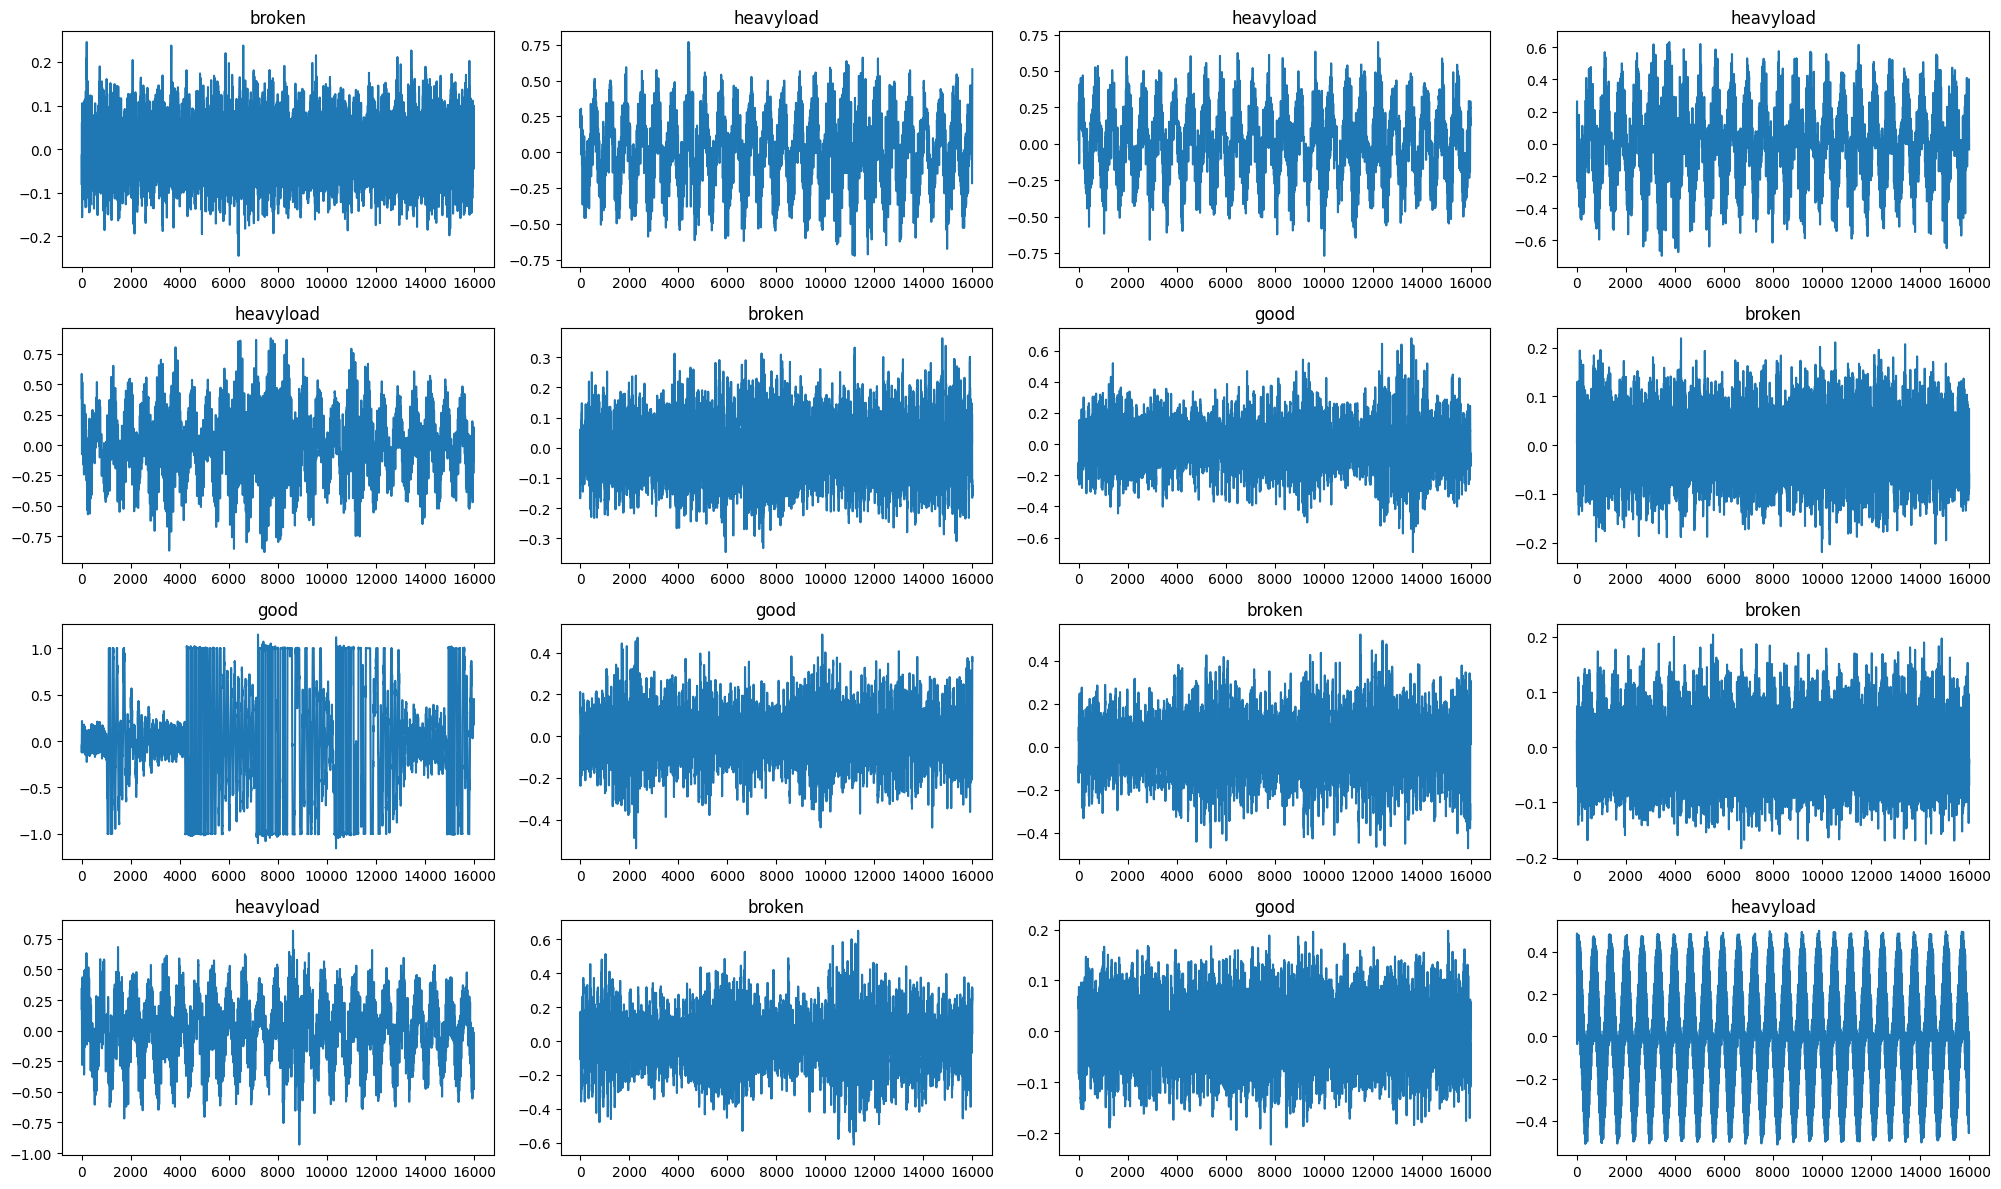

In [ ]:
# Function to decode the label from one-hot encoding
def decode_label(one_hot_label):
    return categories[tf.argmax(one_hot_label).numpy()]

# Number of rows and columns for the plot
row, col = 4, 4
n = row * col
fig, axs = plt.subplots(row, col, figsize=(20, 12))

# Plotting waveforms
for i, (audio, label) in enumerate(train_dataset.unbatch().take(n)):
    r = i // col
    c = i % col
    ax = axs[r][c]
    ax.plot(audio.numpy())

    decoded_label = decode_label(label)
    ax.set_title(decoded_label)

plt.tight_layout()
plt.show()

### Construct Spectrograms

In [ ]:
# Function to convert waveform to spectrogram
def waveform_to_spectrogram(waveform, label):
    # Ensure the waveform has the correct shape
    waveform = tf.squeeze(waveform, axis=-1)

    # Convert waveform to spectrogram
    spectrogram = tf.signal.stft(waveform, frame_length=256, frame_step=128)
    spectrogram = tf.abs(spectrogram)

    # Expand dims to add channel dimension for compatibility with Conv2D layers
    spectrogram = tf.expand_dims(spectrogram, axis=-1)

    return spectrogram, label

# Function to convert an entire dataset to spectrograms
def convert_to_spectrograms(dataset):
    return dataset.map(waveform_to_spectrogram, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
# Convert all datasets to spectrograms
train_spectrogram_ds = convert_to_spectrograms(train_dataset)
val_spectrogram_ds = convert_to_spectrograms(val_dataset)
test_spectrogram_ds = convert_to_spectrograms(test_dataset)

In [ ]:
for spectrogram, label in train_spectrogram_ds.take(1):
    print('Spectrogram shape:', spectrogram.shape)
    print('Label shape:', label.shape)

Spectrogram shape: (32, 124, 129, 1)
Label shape: (32, 3)


In [ ]:
# train_spectrogram_ds = train_spectrogram_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
# val_spectrogram_ds = val_spectrogram_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
# test_spectrogram_ds = test_spectrogram_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

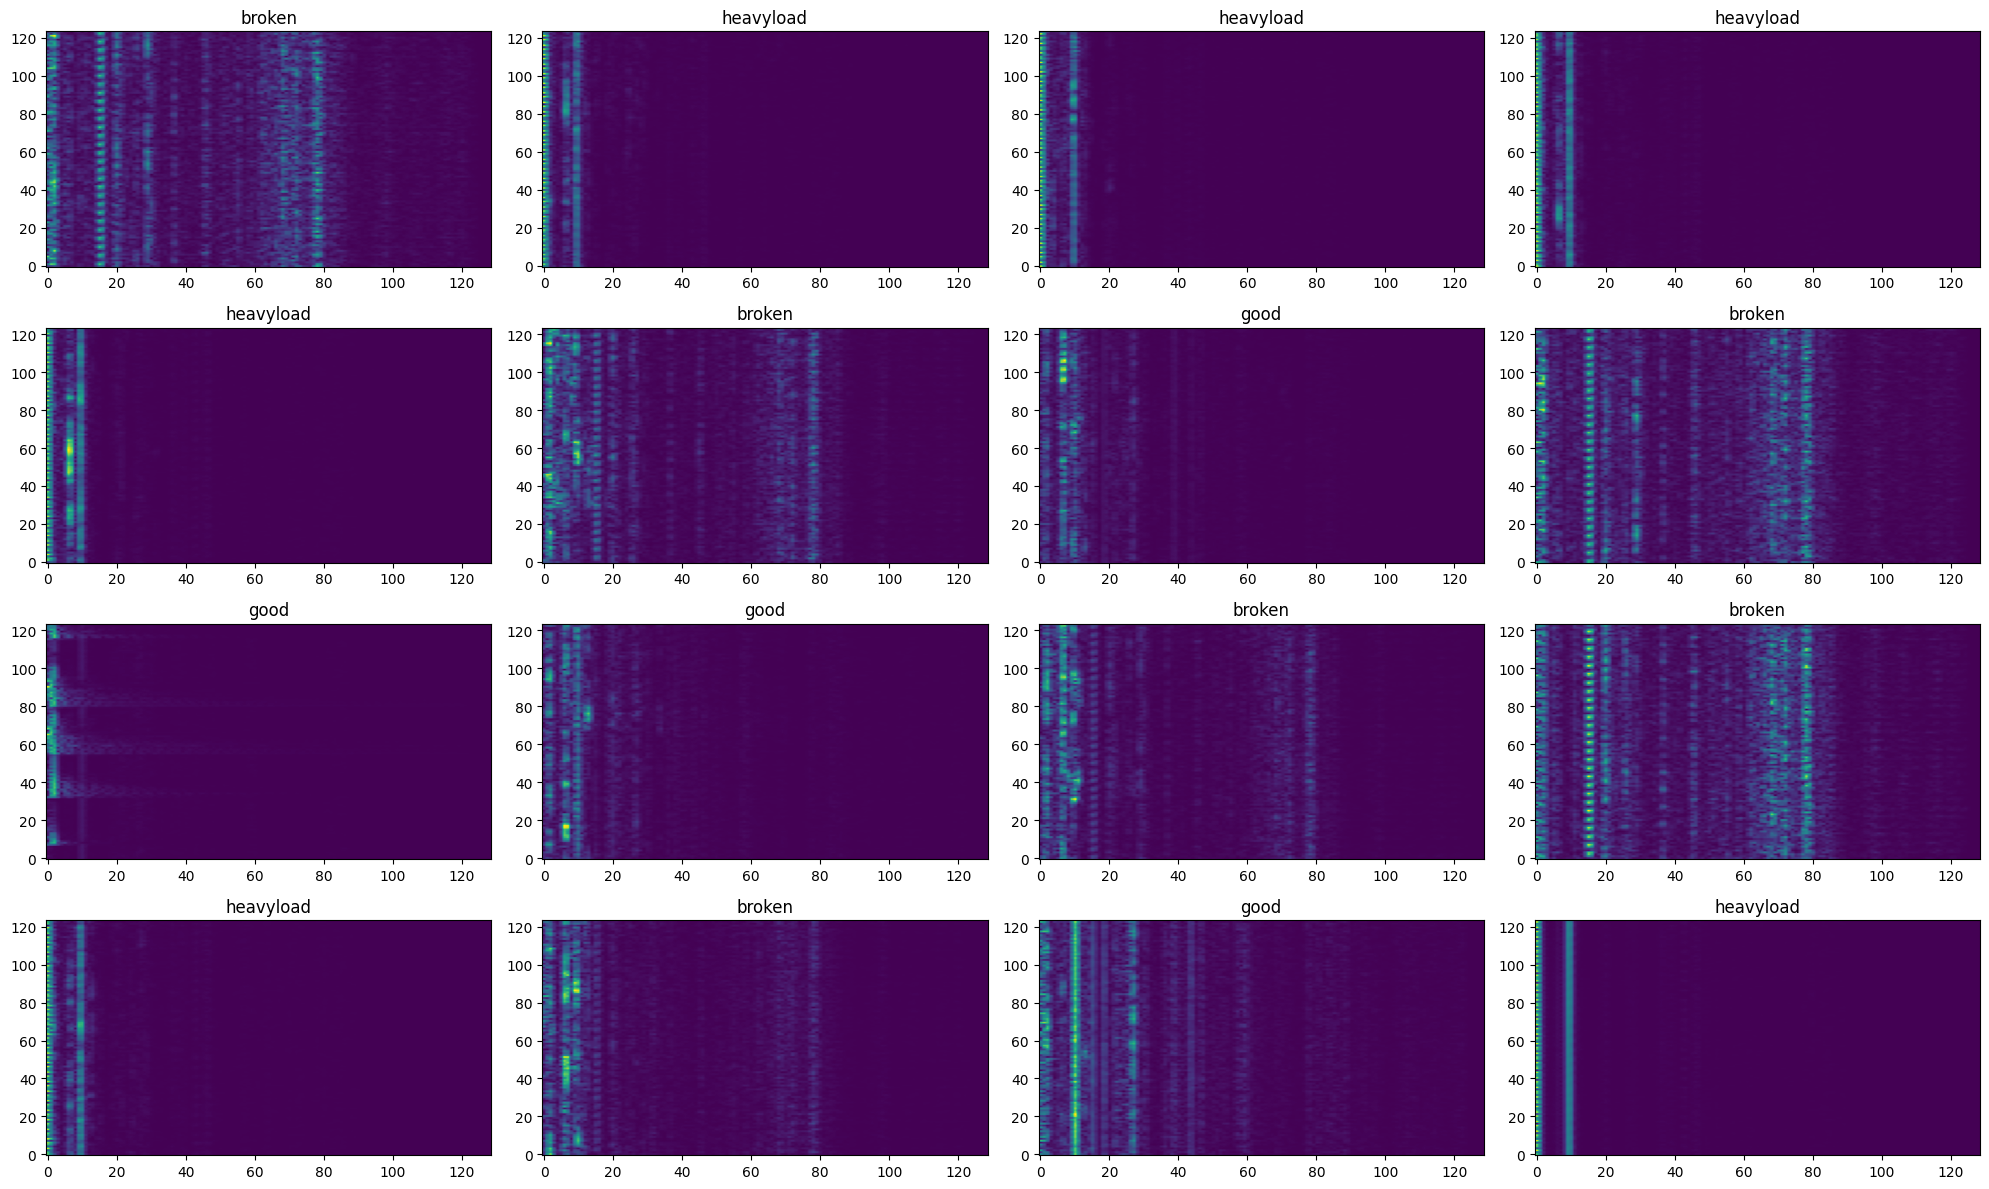

In [ ]:
# Number of rows and columns for the plot
row, col = 4, 4
n = row * col
fig, axs = plt.subplots(row, col, figsize=(20, 12))

# Plotting spectrograms
for i, (spectrogram, label) in enumerate(train_spectrogram_ds.unbatch().take(n)):
    r = i // col
    c = i % col
    ax = axs[r][c]
    spectrogram_np = spectrogram.numpy()
    ax.imshow(spectrogram_np[:, :, 0], aspect='auto', origin='lower')

    decoded_label = decode_label(label)
    ax.set_title(decoded_label)

plt.tight_layout()
plt.show()

### Check distributions in datasets

In [ ]:
def get_class_distribution(dataset):
    labels = []
    for _, label_batch in dataset:
        labels.extend([np.argmax(label) for label in label_batch.numpy()])
    label_counts = collections.Counter(labels)
    return label_counts

# Get class distribution for training and validation datasets
train_class_distribution = get_class_distribution(train_spectrogram_ds)
val_class_distribution = get_class_distribution(val_spectrogram_ds)

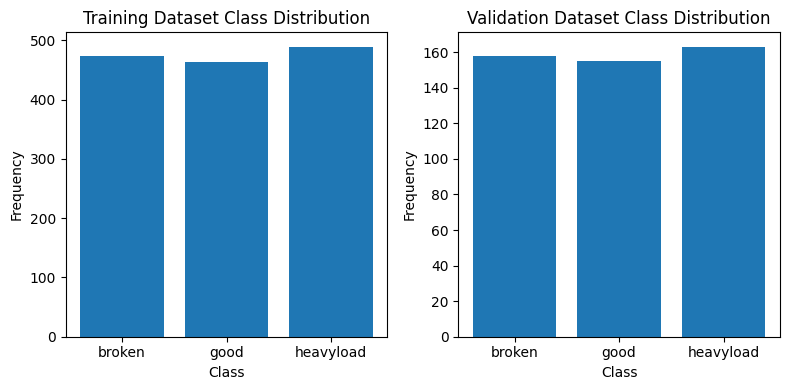

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Training dataset distribution
ax[0].bar(categories, [train_class_distribution[i] for i in range(len(categories))])
ax[0].set_title('Training Dataset Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Frequency')

# Validation dataset distribution
ax[1].bar(categories, [val_class_distribution[i] for i in range(len(categories))])
ax[1].set_title('Validation Dataset Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Modeling

### RNN - waveform

In [ ]:
def rnn_model(input_shape, num_classes, lstm_units=128, dense_units=64):
    input = Input(shape=input_shape)
    x = LSTM(lstm_units, return_sequences=True)(input)
    x = BatchNormalization()(x)
    x = LSTM(lstm_units)(x)
    x = Dense(dense_units, activation='relu')(x)
    x = BatchNormalization()(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input, outputs=output)
    return model

In [ ]:
input_shape = (CLIP_SIZE, 1)

rnn_model = rnn_model(input_shape, NUM_CLASSES)

In [ ]:
plateau_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)

loss_function = CategoricalCrossentropy(from_logits=False)

metrics = [CategoricalAccuracy(name='accuracy'), TopKCategoricalAccuracy(k=2, name='top_k_accuracy'),
           F1Score(name='f1_score'), Precision(name='precision'), Recall(name='recall')]

In [ ]:
rnn_model.compile(optimizer=Adam(learning_rate=1e-2),
                  loss=loss_function,
                  metrics=metrics)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 16000, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 16000, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
history_rnn = rnn_model.fit(train_dataset,
                            validation_data=val_dataset,
                            epochs=30,
                            callbacks=[plateau_callback],
                            class_weight=normalized_class_weights,
                            verbose=1)

Epoch 1/30
45/45 [==============================] - 62s 1s/step - loss: 0.3446 - accuracy: 0.5281 - top_k_accuracy: 0.8626 - f1_score: 0.5247 - precision: 0.5704 - recall: 0.4516 - val_loss: 2.2309 - val_accuracy: 0.3256 - val_top_k_accuracy: 0.6576 - val_f1_score: 0.1638 - val_precision: 0.3256 - val_recall: 0.3256 - lr: 0.0100
Epoch 2/30
45/45 [==============================] - 53s 1s/step - loss: 0.2542 - accuracy: 0.6774 - top_k_accuracy: 0.9173 - f1_score: 0.6657 - precision: 0.7323 - recall: 0.5582 - val_loss: 1.3002 - val_accuracy: 0.3214 - val_top_k_accuracy: 0.6744 - val_f1_score: 0.1690 - val_precision: 0.8649 - val_recall: 0.0672 - lr: 0.0100
Epoch 3/30
45/45 [==============================] - 54s 1s/step - loss: 0.2516 - accuracy: 0.6101 - top_k_accuracy: 0.9201 - f1_score: 0.5886 - precision: 0.6444 - recall: 0.5288 - val_loss: 2.6386 - val_accuracy: 0.3256 - val_top_k_accuracy: 0.6576 - val_f1_score: 0.1638 - val_precision: 0.3256 - val_recall: 0.3256 - lr: 0.0100
Epoch 4

In [ ]:
rnn_model.evaluate(test_dataset)

15/15 [==============================] - 7s 436ms/step - loss: 1.6234 - accuracy: 0.4118 - top_k_accuracy: 0.7038 - f1_score: 0.2968 - precision: 0.4126 - recall: 0.4118


[1.623445987701416,
 0.4117647111415863,
 0.7037814855575562,
 array([0.03680981, 0.29999998, 0.55348045], dtype=float32),
 0.4126315712928772,
 0.4117647111415863]

### Custom CNN - spectrogram

In [ ]:
# Define the custom CNN model
def cnn_model(input_shape, num_classes):
    model = Sequential()

    # Convolutional Blocks Section
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Flatten and Dense Section
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [ ]:
plateau_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)

loss_function = CategoricalCrossentropy(from_logits=False)

metrics = [CategoricalAccuracy(name='accuracy'), TopKCategoricalAccuracy(k=2, name='top_k_accuracy'),
           F1Score(name='f1_score'), Precision(name='precision'), Recall(name='recall')]

In [ ]:
# Define input shape and number of classes
input_shape = (124, 129, 1)

# Create the model
cnn_model = cnn_model(input_shape, num_classes=NUM_CLASSES)

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=1e-2),
                  loss=loss_function,
                  metrics=metrics)

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 122, 127, 32)      320       
                                                                 
 batch_normalization_2 (Bat  (None, 122, 127, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 61, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 61, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 61, 64)        18496     
                                                                 
 batch_normalization_3 (Bat  (None, 59, 61, 64)        2

In [ ]:
history = cnn_model.fit(train_spectrogram_ds,
                        validation_data=val_spectrogram_ds,
                        epochs=30,
                        class_weight=class_weights,
                        callbacks=[plateau_callback],
                        verbose=1)

Epoch 1/30
45/45 [==============================] - 15s 166ms/step - loss: 1.6152e-04 - accuracy: 0.9579 - top_k_accuracy: 0.9888 - f1_score: 0.9580 - precision: 0.9619 - recall: 0.9551 - val_loss: 3.5655 - val_accuracy: 0.6702 - val_top_k_accuracy: 0.7269 - val_f1_score: 0.5712 - val_precision: 0.6773 - val_recall: 0.6702 - lr: 0.0100
Epoch 2/30
45/45 [==============================] - 6s 135ms/step - loss: 2.5074e-05 - accuracy: 0.9944 - top_k_accuracy: 0.9993 - f1_score: 0.9944 - precision: 0.9944 - recall: 0.9944 - val_loss: 0.2806 - val_accuracy: 0.9580 - val_top_k_accuracy: 0.9937 - val_f1_score: 0.9579 - val_precision: 0.9580 - val_recall: 0.9580 - lr: 0.0100
Epoch 3/30
45/45 [==============================] - 6s 124ms/step - loss: 2.1458e-05 - accuracy: 0.9958 - top_k_accuracy: 0.9986 - f1_score: 0.9958 - precision: 0.9958 - recall: 0.9958 - val_loss: 0.1744 - val_accuracy: 0.9790 - val_top_k_accuracy: 0.9958 - val_f1_score: 0.9790 - val_precision: 0.9790 - val_recall: 0.9790 -

In [ ]:
cnn_model.evaluate(test_spectrogram_ds)

15/15 [==============================] - 1s 77ms/step - loss: 0.0011 - accuracy: 1.0000 - top_k_accuracy: 1.0000 - f1_score: 1.0000 - precision: 1.0000 - recall: 1.0000


[0.0010787617648020387, 1.0, 1.0, array([1., 1., 1.], dtype=float32), 1.0, 1.0]

In [ ]:
# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Make predictions for the test dataset
for spectrogram_batch, label_batch in test_spectrogram_ds:
    true_labels.extend([decode_label(label) for label in label_batch])

    # Check the number of spectrograms and labels in the batch
    num_spectrograms = len(spectrogram_batch)
    num_labels = len(label_batch)
    print("Number of spectrograms in batch:", num_spectrograms)
    print("Number of labels in batch:", num_labels)

    # Make predictions for the entire batch
    predictions = cnn_model.predict(spectrogram_batch)

    # Decode predicted labels for the batch
    predicted_labels.extend([decode_label(pred) for pred in predictions])

print("Length of true_labels:", len(true_labels))
print("Length of predicted_labels:", len(predicted_labels))

Number of spectrograms in batch: 32
Number of labels in batch: 32
1/1 [==============================] - 0s 322ms/step
Number of spectrograms in batch: 32
Number of labels in batch: 32
1/1 [==============================] - 0s 30ms/step
Number of spectrograms in batch: 32
Number of labels in batch: 32
1/1 [==============================] - 0s 32ms/step
Number of spectrograms in batch: 32
Number of labels in batch: 32
1/1 [==============================] - 0s 18ms/step
Number of spectrograms in batch: 32
Number of labels in batch: 32
1/1 [==============================] - 0s 20ms/step
Number of spectrograms in batch: 32
Number of labels in batch: 32
1/1 [==============================] - 0s 24ms/step
Number of spectrograms in batch: 32
Number of labels in batch: 32
1/1 [==============================] - 0s 18ms/step
Number of spectrograms in batch: 32
Number of labels in batch: 32
1/1 [==============================] - 0s 21ms/step
Number of spectrograms in batch: 32
Number of labels in

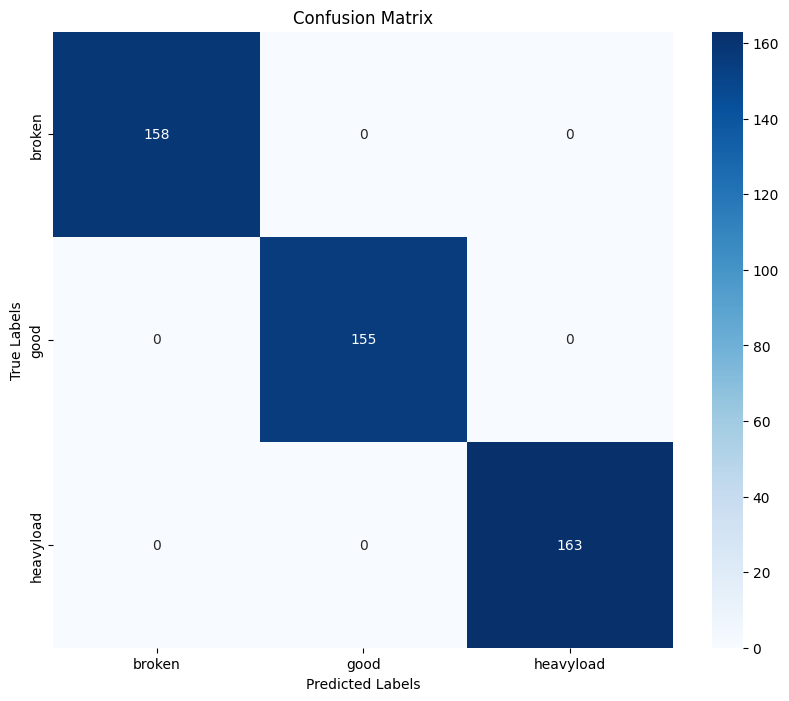

In [ ]:
# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=categories)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### EfficientNetB4

In [ ]:
# Prepare the datasets by converting grayscale to rgb

# Function to convert a single grayscale spectrogram to RGB
def grayscale_to_rgb(spectrogram, label):
    rgb_spectrogram = tf.image.grayscale_to_rgb(spectrogram)
    return rgb_spectrogram, label

# Apply the conversion to the datasets
train_spectrogram_ds_rgb = train_spectrogram_ds.map(grayscale_to_rgb)
val_spectrogram_ds_rgb = val_spectrogram_ds.map(grayscale_to_rgb)
test_spectrogram_ds_rgb = test_spectrogram_ds.map(grayscale_to_rgb)

# Verify the shapes
for rgb_spectrogram, label in train_spectrogram_ds_rgb.take(1):
    print('RGB Spectrogram shape:', rgb_spectrogram.shape)
    print('Label:', label)

RGB Spectrogram shape: (32, 124, 129, 3)
Label: tf.Tensor(
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]], shape=(32, 3), dtype=float32)


In [ ]:
efficient_netB4 = tf.keras.applications.EfficientNetB4(include_top=False,
                                                       weights='imagenet',
                                                       input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_SIZE[2]))

efficient_netB4.trainable = False

71686520/71686520 [==============================] - 0s 0us/step


In [ ]:
input = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_SIZE[2]))

x = efficient_netB4(input, training=False)

x = GlobalAveragePooling2D()(x)
x = Dense(DENSE_UNITS_1, activation='relu', kernel_regularizer=L2(0.001))(x)
x = BatchNormalization()(x)
x = Dense(DENSE_UNITS_2, activation='relu', kernel_regularizer=L2(0.001))(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

efficient_netB4_model = Model(input, output)

efficient_netB4_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 124, 129, 3)]     0         
                                                                 
 efficientnetb4 (Functional  (None, 4, 5, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1792)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_5 (Dense)             (None, 1024)              1836032   
                                                                 
 batch_normalization_7 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                           

In [ ]:
plateau_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)

loss_function = CategoricalCrossentropy(from_logits=False)

metrics = [CategoricalAccuracy(name='accuracy'), TopKCategoricalAccuracy(k=2, name='top_k_accuracy'),
           F1Score(name='f1_score'), Precision(name='precision'), Recall(name='recall')]

In [ ]:
efficient_netB4_model.compile(optimizer=Adam(learning_rate=1e-2),
                              loss = loss_function,
                              metrics = metrics)

In [ ]:
history_enB4 = efficient_netB4_model.fit(train_spectrogram_ds_rgb,
                                         validation_data=val_spectrogram_ds_rgb,
                                         epochs=30,
                                         class_weight=class_weights,
                                         callbacks=[plateau_callback],
                                         verbose=1)

Epoch 1/30
45/45 [==============================] - 29s 278ms/step - loss: 0.1284 - accuracy: 0.9116 - top_k_accuracy: 0.9811 - f1_score: 0.9115 - precision: 0.9191 - recall: 0.8997 - val_loss: 0.7092 - val_accuracy: 0.6471 - val_top_k_accuracy: 0.9958 - val_f1_score: 0.5591 - val_precision: 0.6868 - val_recall: 0.5021 - lr: 0.0100
Epoch 2/30
45/45 [==============================] - 7s 157ms/step - loss: 0.0067 - accuracy: 0.9264 - top_k_accuracy: 0.9797 - f1_score: 0.9262 - precision: 0.9354 - recall: 0.9236 - val_loss: 0.7886 - val_accuracy: 0.6408 - val_top_k_accuracy: 0.7626 - val_f1_score: 0.5316 - val_precision: 0.9728 - val_recall: 0.5252 - lr: 0.0100
Epoch 3/30
45/45 [==============================] - 7s 162ms/step - loss: 0.0041 - accuracy: 0.9530 - top_k_accuracy: 0.9930 - f1_score: 0.9528 - precision: 0.9562 - recall: 0.9495 - val_loss: 0.8266 - val_accuracy: 0.5462 - val_top_k_accuracy: 0.7920 - val_f1_score: 0.4618 - val_precision: 0.5975 - val_recall: 0.5021 - lr: 0.0100


In [ ]:
efficient_netB4_model.evaluate(test_spectrogram_ds)

15/15 [==============================] - 5s 93ms/step - loss: 0.0634 - accuracy: 0.9811 - top_k_accuracy: 0.9916 - f1_score: 0.9811 - precision: 0.9873 - recall: 0.9811


[0.06343589723110199,
 0.9810924530029297,
 0.9915966391563416,
 array([0.99047625, 0.974359  , 0.9784615 ], dtype=float32),
 0.9873149991035461,
 0.9810924530029297]